# This Building Does Not Exist (Yet)

## AIASF _NEXT_ 2019
### Tyler Kvochick
### TEECOM Research & Development

# Goals

## Beyond Metaphors

What is a neural network, literally?

## Inner Workings

What makes a neural network...work?

## Applications

What interesting models exist today and what can we make them do?

(Hint: we can make sketchy floorplans)

## Ultimately...

To be unimpressed with machine learning jargon

And to see machine learning as a practical tool rather than a mysterious buzzword

# Setup

* All of this is happening in a remote Linux server
* Under `Runtime` (above), select `Change Runtime Type` and set `Hardware Accelerator` to `GPU`
* Use the demo cell to understand syntax & notebook environment
* Install a network visualization module
* Import libraries

In [0]:
# Demo cell!

# Each light gray block (cell) can just be copied and pasted into the Colab notebook
# Select the cell and hit Shift + Enter to execute it
# The output for each cell will appear below it as it runs
# When it is finished running, a number will appear in brackets at the far top left

# The world's shortest Python tutorial:

# Any text on a line after a `#` will be ignored as a code comment

# Use `def` to define a reusable subroutine (function)
def demo_function(name, number):
    
    # Assign values to identifiers with `=`
    # Use double quotes `""` to make a string
    # Use `"{}".format(...some value...)` to put values into strings
    message = "Hello {}! Welcome to AIASF NEXT!\n".format(name)

    # Do some math
    x = 2
    
    # Raise two to the power that the user specifies with `number`
    result = 2 ** number
    
    # Add that to our message
    message += "2 to the power of {} is {}".format(number, result)
    
    # Print the message
    print(message)
    
    # Give back the result of the math
    return result

# Use parentheses `()` after a function name to call it
# Any arguments that it requires are put in order inside the parens
some_power_of_two = demo_function("Tyler", 8)

# The last value in the cell will be appended to the output
some_power_of_two

# Congrats! You are now a Python programmer

In [0]:
# Commands prefixed with `!` are sent to the runtime's terminal emulator
# Use the system package manager to install a non-standard module and hide the output

!pip install torchviz > /dev/null

In [0]:
# Import a lot of packages for interacting with the filesystem, doing math, working with images, and building neural networks

import sys
import os
import math
import time
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as nnf
import torch.optim as optim
import matplotlib
import matplotlib.pyplot as plt
from torchviz import make_dot
import torchvision.transforms as transforms
import torchvision.utils as vutils

# Configure the interactive plot size
matplotlib.rcParams["figure.figsize"] = (8, 6)

# Beyond Metaphors

What does a neural network look like?

These are just concepts, we will look at literal versions in section 2.

In [0]:
# Demo class just to see multiple representations of a neural network

class NetworkVisualization(nn.Module):
    def __init__(self):
        super(NetworkVisualization, self).__init__()
        
        # Add 2 sets of layers 
        # Set 0
        self.conv0 = nn.Conv2d(3, 6, (3, 3))
        self.act0 = nn.LeakyReLU()
        # Set 1
        self.conv1 = nn.Conv2d(3, 6, (3, 3))
        self.act1 = nn.LeakyReLU()
    
    def forward(self, x):
        # Use both sets of layers
        x0 = self.act0(self.conv0(x))
        x1 = self.act1(self.conv1(x))
        
        # Sum the result
        return x0 + x1

In [0]:
# Create an instance of our class
nv = NetworkVisualization().cuda()

# Create a fake image made of white noise with the sizes: (1 batch, 3 channels (RGB), 512 pixels high, 512 pixels wide)
# Shapes are very important in deep learning
fake_image = torch.randn(1, 3, 512, 512).cuda()

# Use the created instance
out = nv(fake_image)

# Examine how the neural network changed the shape of our input
print("Output shape: {}".format(out.shape))
print(nv)

In [0]:
# Render the graph
make_dot(out)

In [0]:
# Render the parameters
params = [p for p in list(nv.conv0.parameters())]
print(params)

# No More Metaphors (Summary)

## Multiple Representations of NNs

1. As executable code / structured data (software)
2. As a connective graph (visualization)
3. As lists of numbers organized into rectilinear shapes (tensors)

---

# Inner Workings

We have seen that deep learning models are full of orthogonal collections of numbers that we call tensors. The rest of the model is made of mathematical functions for combining those tensors.

## Convolution

For working with images, the most common function for combining tensors in a learnable way is called convolution.

Convolution is a confusing name for "searching for known patterns".

To get a better intuitive understanding of what convolution is, we are going to look at a 1D example.

In [0]:
# Convolution comes from signal processing
# Look at a simple one-dimensional signal

lim = 8 * np.pi
x_axis = np.linspace(-lim, lim, 200)
sin_x = np.sin(x_axis)

plt.plot(x_axis, sin_x, label="sin(x)")
plt.legend()

In [0]:
# Define a special signal that has some interesting event which we will train a model to recognize
# Analogous to "Hey Siri" or "Ok, Google"

def special_signal():
    low = -12 * np.pi
    high = 4 * np.pi
    
    space_s = np.linspace(2 * low, 2 * high, 210)
    space = np.linspace(-8 * np.pi, 8 * np.pi, 210)
    
    noise = np.random.randn(space.size) * 0.03
    
    event = np.sin(space_s) / space_s
    
    base_signal = np.sin(space) * noise
    
    return base_signal + event
    
ss = special_signal()

plt.plot(ss, label="special signal")
plt.vlines([140, 171], -0, 1, linestyles="--")
plt.legend()

In [0]:
label = np.zeros_like(ss)
label[140:171] = 1.0

plt.plot(ss, label="special signal")
plt.plot(label, label="label")

In [0]:
# Define convolution from scratch

def convolve(signal, kernel, stride=1):
    # Establish starting shapes
    signal_width = signal.shape[0]
    kernel_width = kernel.shape[0]
    
    # Use shapes to get ratios
    number_of_positions = signal_width // stride

    # Define empty collections to save results
    out = []
    input_slices = []
    
    for i in range(number_of_positions):
        # Start at some point in the signal we are searching
        start_index = i * stride
        
        # Take a subset of that signal
        this_slice = signal[start_index:start_index + kernel_width]
        
        # More shape management
        this_slice_width = this_slice.shape[0]
        
        # Ensure that our subset is the same shape as our kernel
        this_slice = np.pad(this_slice, (0, kernel_width - this_slice_width), 'constant')
        
        # Save our input for later
        input_slices.append(this_slice)
        
        # The main event of convolution!
        
        # Element-wise multiplication...
        product = this_slice * kernel
        
        # ...and a sum of all of the results
        summation = np.sum(product)
        out.append(summation)

    # Return the result and the input (we will want that later)
    return np.array(out), np.stack(input_slices)
        

In [0]:
# Examine one step of applying convolution

# Fill a kernel with random numbers
kernel = np.random.randn(30)

# Do the thing
output, input_slices = convolve(ss, kernel, stride=1)


plt.plot(ss, label="special signal")
plt.plot(label, label="label")
plt.plot(output, label="output")
plt.legend()

In [0]:
# Define a metric to measure how far off we are

def squared_error(output, target):
    error = target - output
    sq_error = (error ** 3) / np.abs(error)
    return sq_error

se = squared_error(output, label)
plt.plot(ss, label="special signal")
plt.plot(label, label="label")
plt.plot(output, label="output")
plt.plot(se, label="error")
plt.legend()

## Things Required to Make Machines Learn

1. Input
2. Label

(Dataset)

3. Function to transform Input -> Label (Convolution)
4. Function to measure how far off the output is from the label (Squared Error)

(Model)

5. A way to update kernel based on how far off the output is

(Backpropagation, i.e. derivatives)

$$ O(\mathbf{I}) = \mathbf{I} \cdot \mathbf{k} $$
$$\frac{\delta O}{\delta \mathbf{k}} = \mathbf{I} $$

We can use this derivative to attribute how much the combination of our input and kernel contribute to our error

When we know the magnitude of that contribution, we can use it to guide our kernel to better and better results

In [0]:
# Apply our convolution function to learn about the event in the special signal

kernel = np.random.randn(30)
learning_rate = 0.0005
losses = []
number_of_tries = 1000

for try_number in range(number_of_tries):
    # Use our convolution function
    output, input_slices = convolve(ss, kernel)
    
    # Measure how far off we are
    se = squared_error(output, label)
    
    # Average the error to produce a loss
    loss = se.mean()
    
    # Save loss to track model progress
    losses += [loss]
    
    # Print out our progress every 50th try
    if try_number % 50 == 0:
        print("Mean Squared Error Loss: {:.4f}".format(loss))
    
    # Manual backpropagation
    for (error, in_slice) in zip(se, input_slices):
        
        # Use error, input signal, and learning rate to attribute
        # an update amount to each element of our kernel
        
        kernel_update = error * in_slice * learning_rate
        
        # Apply the update to our kernel to shift it closer next time
        
        kernel = kernel + kernel_update

# Save losses for plotting
losses = np.array(losses)       

In [0]:
# Plot trained output and label

ssr = ss

output_r, _ = convolve(ssr, kernel)

plt.plot(ssr, label="special signal")
plt.plot(label, label="label")
plt.plot(output_r, label="output")
plt.legend()

In [0]:
# Smooth and plot

def gaussian_kernel(mu=0, sigma=1, width=30):
    x = np.linspace(-sigma, 2 * sigma, width)
    y = np.linspace(-sigma, 2 * sigma, width)
    exp = np.e ** (-1 * (x - mu) ** 2)/(2 * sigma ** 2)
    
    return (1 / (sigma * np.sqrt(2 * np.pi))) * exp

smooth, _ = convolve(output, gaussian_kernel())

plt.plot(ss, label="special signal")
plt.plot(label, label="label")
plt.plot(smooth / smooth.max(), label="smoothed output")

plt.legend()

# We can interpret this as "I am 100% confident that the event that I am trained for starts at x = 140"

In [0]:
# Plot and print kernel

print(kernel)
plt.plot(kernel, label="kernel")
plt.legend()

In [0]:
# Plot loss over time

plt.plot(losses, label="loss over time")
plt.legend()

# How does it work (Summary)

Neural networks use (fairly) simple mathematical functions to discover non-obvious solutions.
These are not found by describing complex rules, but merely by describing relationships between inputs and desired outputs.

We can use ideas from calculus and linear algebra to start from random values that transform from input to output and steer the output towards better and better results.

# Applications

## Generative Models

One of the fascinating things about deep neural nets is that they can learn arbitrary, _qualitative_ functions.

Functions like "generate images that are similar to this collection of images".

And this can be done with operations similar to what we have just written.

In [17]:
# Download directory of images for dataset
# Directory should have at least one subdirectory that contains all images
# i.e. /ALotOfPlansModified/all/plan_1.jpg, ...plan_2.jpg, ...good_building_plan.jpg, etc.

!wget https://www.dropbox.com/sh/v7uu10rkve2vnt8/AAA6InT1OjUquORG0i1syD7ka?dl=0 -O ALotOfPlans.zip > /dev/null
!unzip ALotOfPlans.zip -d . > /dev/null

--2019-06-26 21:41:45--  https://www.dropbox.com/sh/v7uu10rkve2vnt8/AAA6InT1OjUquORG0i1syD7ka?dl=0
Resolving www.dropbox.com (www.dropbox.com)... 162.125.8.1, 2620:100:601b:1::a27d:801
Connecting to www.dropbox.com (www.dropbox.com)|162.125.8.1|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /sh/raw/v7uu10rkve2vnt8/AAA6InT1OjUquORG0i1syD7ka [following]
--2019-06-26 21:41:45--  https://www.dropbox.com/sh/raw/v7uu10rkve2vnt8/AAA6InT1OjUquORG0i1syD7ka
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc2294aa9435d4d4374d377b8f9f.dl.dropboxusercontent.com/zip_by_token_key?key=AjlmBX0c_09pDQijTfDoMFraJZPMe3hOhbmrjs9nRnjbuXpxk7afxuGaJoJV65UMltuNIXC706jo6bGRU7z-YCDbJGP38qURdpSWwkt1ZXOXviwMXBCWLvZMOTnIOUo2KMALsyzaIlE4mgQsqIe4qNc9RfqMLiAGrQb9NlWnkcBvkVSzDVUyQwumbtNVRy1D6ByTh0WF22d3hz2DPY9htAzOEDm1f0ySqq8vA0fP-dnLIKtPTM06n3DhIAOET19mFHdQnxcZ71xzN7ZyQDM3qz9C [following]
--2019-06-26 21

In [1]:
# Download AEGeAN module
!curl https://raw.githubusercontent.com/TEECOM/this-building-does-not-exist/spaceheater-training/ml/python/AEGeAN.py --output AEGeAN.py > /dev/null

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 10548  100 10548    0     0  63542      0 --:--:-- --:--:-- --:--:-- 63161


In [2]:
# Download pretrained weights files

!wget https://www.dropbox.com/s/rr9xvcijs5k4mxb/1561579878-discriminator.pth?dl=0 -O discriminator.pth > /dev/null
!wget https://www.dropbox.com/s/5fn9jiaulsxz9fx/1561579878-generator.pth?dl=0 -O generator.pth > /dev/null

--2019-06-26 21:36:55--  https://www.dropbox.com/s/rr9xvcijs5k4mxb/1561579878-discriminator.pth?dl=0
Resolving www.dropbox.com (www.dropbox.com)... 162.125.8.1, 2620:100:601b:1::a27d:801
Connecting to www.dropbox.com (www.dropbox.com)|162.125.8.1|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/rr9xvcijs5k4mxb/1561579878-discriminator.pth [following]
--2019-06-26 21:36:55--  https://www.dropbox.com/s/raw/rr9xvcijs5k4mxb/1561579878-discriminator.pth
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc4779cf9db36dbcca18c7c3cc3c.dl.dropboxusercontent.com/cd/0/inline/AjnKdgyDYrWsfIdmgFW7TWv3WutbbLFbd0Ew09lx2yTQDbXg0IWfYKeYUP6jE0gJTZWGRuRY7zv-qBpnFB73BHF_A9WHzQFsiHQ5SWc8Vx8ZIw/file# [following]
--2019-06-26 21:36:55--  https://uc4779cf9db36dbcca18c7c3cc3c.dl.dropboxusercontent.com/cd/0/inline/AjnKdgyDYrWsfIdmgFW7TWv3WutbbLFbd0Ew09lx2yTQDbXg0IWfYKeYUP6jE0gJTZWGRuRY7zv-qBpnFB

In [0]:
# Import a generative network framework for generating architectural drawings

from AEGeAN import AEGeAN, Generator, Discriminator

In [0]:
# Define the core function of the AEGeAN generative network

class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=4, stride=2, padding=1):
        super().__init__()

        self.conv = nn.ConvTranspose2d(
            in_channels,
            out_channels,
            kernel_size,
            stride,
            padding,
            bias=False
            )

        self.bn = nn.BatchNorm2d(out_channels)

    def forward(self, x):
        y = self.conv(x)
        y = self.bn(y)

        return nnf.leaky_relu(y, negative_slope=0.2)

In [15]:
# Create a generator network using our custom ConvBlock
G = Generator.Generator(ConvBlock, feature_coeff=4, out_channels=1)

# Create a discriminator to use with our generator
D = Discriminator.Discriminator(Discriminator.ConvBlock, feature_coeff=4, in_channels=1)

# Load pretrained weights to start our network in a favorable state

state_dictionaries = {
    "generator": torch.load("generator.pth"),
    "discriminator": torch.load("discriminator.pth")
}


G.load_state_dict(state_dictionaries["generator"])
D.load_state_dict(state_dictionaries["discriminator"])

G.cuda()
D.cuda()

Discriminator(
  (main): Sequential(
    (cb0): ConvBlock(
      (conv): Conv2d(1, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (bn): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (cb1): ConvBlock(
      (conv): Conv2d(32, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (bn): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (cb2): ConvBlock(
      (conv): Conv2d(32, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (bn): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (cb3): ConvBlock(
      (conv): Conv2d(32, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (bn): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (cb4): ConvBlock(
      (conv): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  

In [0]:
# Turn the downloaded directory of images into a dataset

dataloader, n_batches = AEGeAN.image_dataset("alotofplansmodified", batch_size=4)

Epoch [   0/ 100] Batch [   0/  65]
Encoded: [Mu: 0.0682 Sd: 0.1779]
Losses [AE: 0.1695 Real: 0.6356 Fake: 0.7542 Generator: 0.6389]


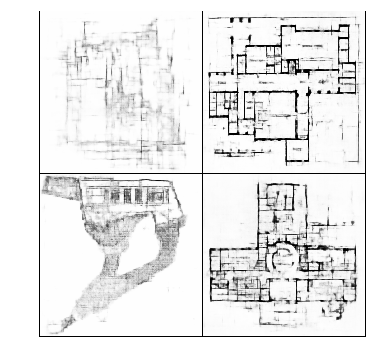

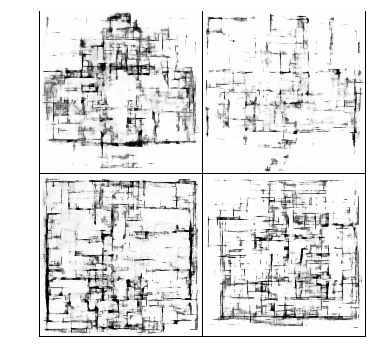

Epoch [   0/ 100] Batch [  20/  65]
Encoded: [Mu: 0.0686 Sd: 0.1684]
Losses [AE: 0.1688 Real: 0.6151 Fake: 0.7669 Generator: 0.6286]


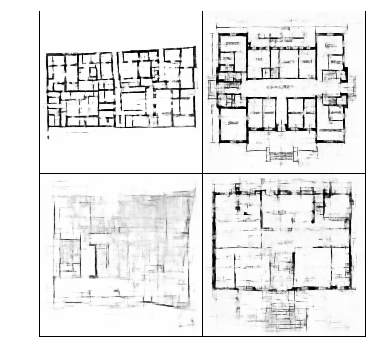

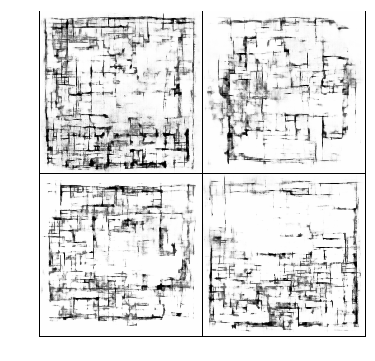

Epoch [   0/ 100] Batch [  40/  65]
Encoded: [Mu: 0.0689 Sd: 0.1707]
Losses [AE: 0.1579 Real: 0.6081 Fake: 0.7848 Generator: 0.6145]


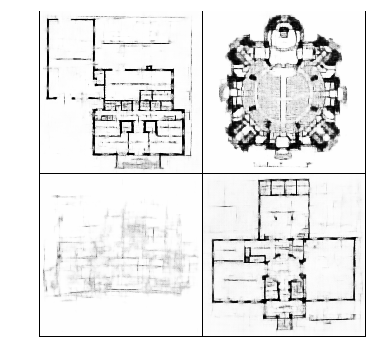

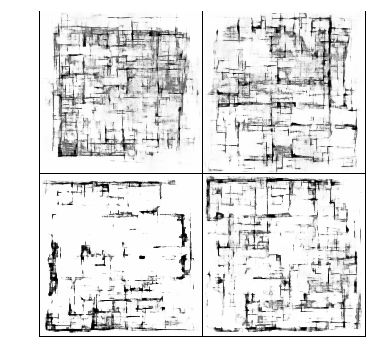

Epoch [   0/ 100] Batch [  60/  65]
Encoded: [Mu: 0.0729 Sd: 0.1838]
Losses [AE: 0.1423 Real: 0.5987 Fake: 0.8028 Generator: 0.5975]


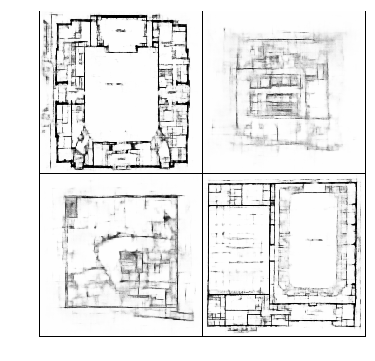

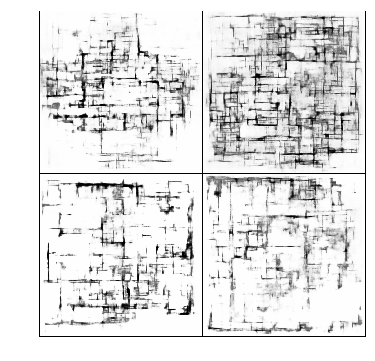

Epoch [   1/ 100] Batch [   0/  65]
Encoded: [Mu: 0.0718 Sd: 0.1760]
Losses [AE: 0.2298 Real: 0.5817 Fake: 0.8083 Generator: 0.5939]


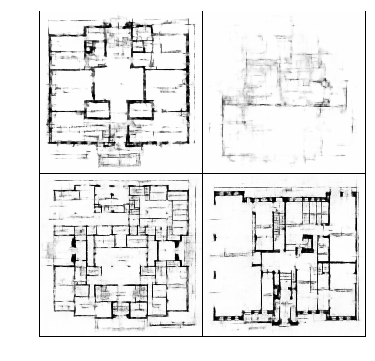

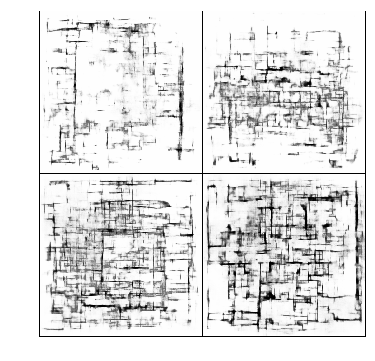

Epoch [   1/ 100] Batch [  20/  65]
Encoded: [Mu: 0.0772 Sd: 0.1851]
Losses [AE: 0.1770 Real: 0.5755 Fake: 0.8180 Generator: 0.5872]


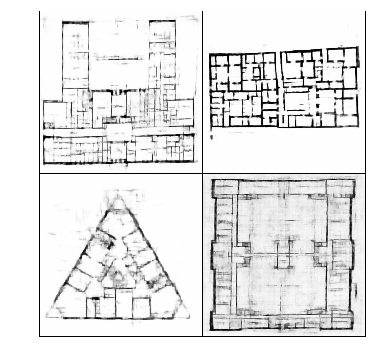

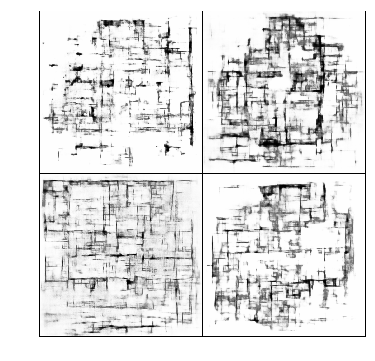

Epoch [   1/ 100] Batch [  40/  65]
Encoded: [Mu: 0.0731 Sd: 0.1744]
Losses [AE: 0.1433 Real: 0.5685 Fake: 0.8330 Generator: 0.5809]


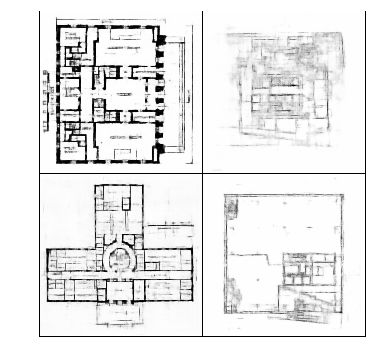

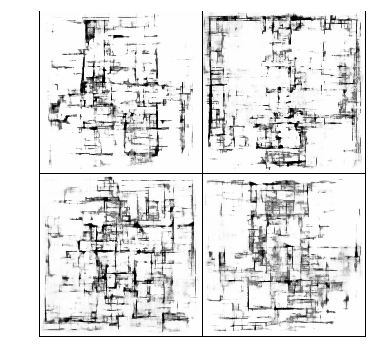

KeyboardInterrupt: ignored

In [33]:
# Function for turning tensors into drawings
to_image = transforms.ToPILImage()

# Number of trips through the dataset
n_epochs = 100

# Learning rate
lr = 5e-4

ae_criterion = nn.BCELoss(reduction="mean").cuda()
d_criterion = nn.BCELoss(reduction="mean").cuda()

for epoch_num in range(n_epochs):
    
    # Create optimizers to adjust the parameters of each model
    g_optim = optim.Adam(G.parameters(), lr=lr)
    d_optim = optim.SGD(D.parameters(), lr=lr, momentum=0.9)

    for batch_num, (data, label) in enumerate(dataloader):

        # Shape management
        batch_size, channels, height, width = data.shape

        # Create label for real images
        real_label = torch.zeros(batch_size, 2, 1, 1).cuda()
        real_label[:, 0, :, :] = 1.0
        
        # Create label for fake images
        fake_label = torch.zeros(batch_size, 2, 1, 1).cuda()
        fake_label[:, 1, :, :] = 1.0

        # Move real images to GPU
        data = data.cuda()

        data.requires_grad = True
        
        #--------------
        # Autoencoder
        #--------------

        # Encode real images into small vector
        encoded = D(data, mode="ae")
        e_mu = encoded.mean().detach()
        e_std = encoded.std().detach()
        
        # Upsample encoded vector back to images
        decoded = G(encoded, mode="ae")

        # Measure how far off we are from recreating the original
        reconstruction_loss = ae_criterion(decoded, data.detach())

        reconstruction_loss.backward()

        g_optim.step()
        d_optim.step()

        g_optim.zero_grad()
        d_optim.zero_grad()

        #--------------
        # Generative Adversarial Network
        #--------------

        # Train discriminator on real images
        classify_real = D(data, mode="discriminator")

        real_loss = d_criterion(classify_real, real_label)

        z = torch.randn(batch_size, 128, 1, 1).cuda()
        z.requires_grad = True

        # Generate fake images
        fake_images = G(z, mode="generator", mu=e_mu, std=e_std)

        # Train discriminator on fake images
        classify_fake = D(fake_images.detach(), mode="discriminator")

        fake_loss = d_criterion(classify_fake, fake_label)

        # Measure total (real & fake classification) performance of discriminator
        d_total_loss = real_loss + fake_loss
        d_total_loss.backward()

        d_optim.step()
        d_optim.zero_grad()

        # Measure how well the generator fooled the discriminator
        classify_generator = D(fake_images, mode="discriminator")

        fooled_loss = d_criterion(classify_generator, real_label)

        fooled_loss.backward()

        g_optim.step()
        g_optim.zero_grad()
        
        # Printing & logging
        now = math.floor(time.time())

        if batch_num % 20 == 0:

            msg =\
                "Epoch [{:4d}/{:4d}] Batch [{:4d}/{:4d}]\n"+\
                "Encoded: [Mu: {:.4f} Sd: {:.4f}]\n"+\
                "Losses [AE: {:.4f} Real: {:.4f} Fake: {:.4f} Generator: {:.4f}]"

            msg = msg.format(
                epoch_num,
                n_epochs,
                batch_num,
                n_batches,
                e_mu.item(),
                e_std.item(),
                reconstruction_loss.item(),
                real_loss.item(),
                fake_loss.item(),
                fooled_loss.item()
            )

            print(msg)


            nrow = int(math.sqrt(batch_size))
            
            decoded_grid = vutils.make_grid(decoded.clone().cpu(), nrow=nrow, normalize=True)
            fake_grid = vutils.make_grid(fake_images.clone().cpu(), nrow=nrow, normalize=True)
            
            plt.imshow(to_image(decoded_grid))
            plt.axis("off")
            plt.show()
            
            plt.imshow(to_image(fake_grid))
            plt.axis("off")
            plt.show()

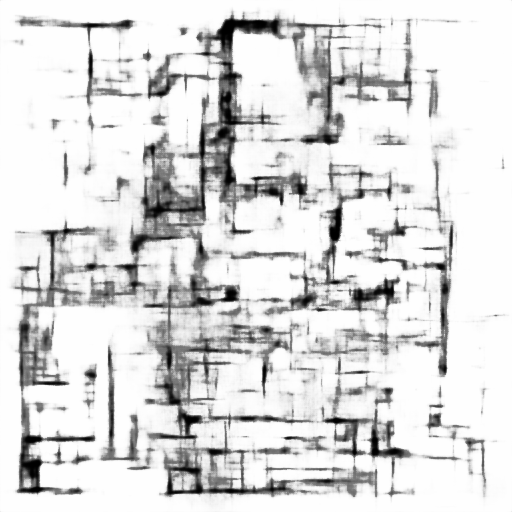

In [32]:
# Generate single image

n_images = 1

z = torch.randn(n_images, 128, 1, 1).cuda()

output = G(z, mode="generator", mu=e_mu, std=e_std)

grid = vutils.make_grid(output.detach().cpu(), nrow=int(math.sqrt(n_images)), normalize=True)

to_image(grid)